In [1]:
import seaborn as sns
import numpy as np

from cobra.io import read_sbml_model
from cobra.core import model
from cobra.flux_analysis import phenotype_phase_plane, pfba
from typing import List, Tuple, Iterable, Any
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
# modified version of plotting.plot_production_envelope
# let's us put multiple planes on the same plot. 
def production_envelope(
        wt_model: model,
        knockouts: Iterable[str],
        carbon_sources: Iterable[str],
        target_reaction: str,
        points: int = 20
) -> pd.DataFrame:
    """Calculates the data of the production envelope for a KO.

    :param wt_model: the Wild-Type model without any knockouts
    :param knockouts: the list of KOs
    :param carbon_sources: the list of carbon sources
    :param target_reaction: the reaction to place on the x-axis of the PPP
    :return: A DataFrame with the biomass yield ranges for each x-value
    """
    ko_model = wt_model.copy()
    for ko in knockouts:
        for k in ko.split('|'):
            ko_model.reactions.get_by_id(k).knock_out()
    for cs in carbon_sources:
        ko_model.reactions.get_by_id("EX_" + cs + "_e").lower_bound = -10.0 / len(carbon_sources)
    return phenotype_phase_plane.production_envelope(
        ko_model, target_reaction, points=points)


def plot_envelope(
        wt_model: model,
        knockouts: Iterable[str],
        carbon_sources: Iterable[str],
        target_reaction: str,
        ax: plt.Axes,
        label: str = None,
        color: Any = 'b'):
    prod_env_df = production_envelope(
        wt_model=wt_model,
        knockouts=knockouts,
        carbon_sources=carbon_sources,
        target_reaction=target_reaction,
        points=200)

    label = label or ','.join(carbon_sources)
    ax.plot(prod_env_df.flux_minimum,
            prod_env_df[target_reaction],
            c=color, ls='-', lw=2, label=label)
    ax.plot(prod_env_df.flux_maximum,
            prod_env_df[target_reaction],
            c=color, ls='-', lw=2, label='')

    ax.fill_betweenx(
        prod_env_df[target_reaction],
        prod_env_df.flux_minimum,
        prod_env_df.flux_maximum,
        linewidth=0,
        alpha=0.2,
        facecolor=color,
        label='')

In [3]:
wt_model = read_sbml_model("core_model_with_rpp.xml")

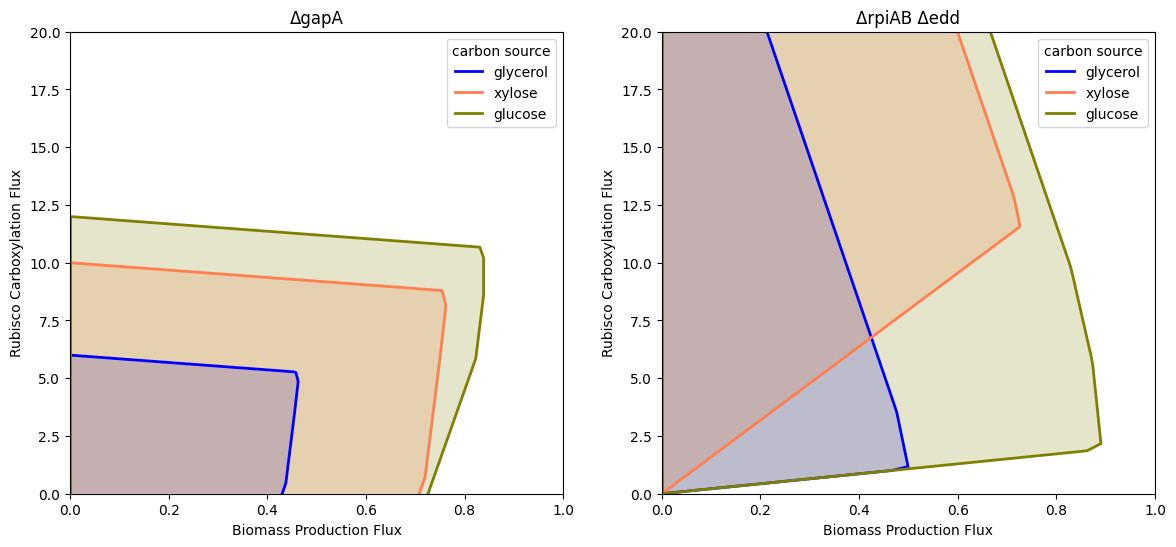

In [4]:
# Colors for plotting
colors = sns.color_palette()

# gapA KO was previously published by Mueller-Cajar '07 and others.
# Plot shows that this strain has slope 0 on sample carbon sources.
fig = plt.figure(figsize=(14, 6))

csources_list = [
    (['dhap'], 'glycerol', "blue"),
    (['xu5p__D'], 'xylose', "coral"),
    (["glc__D"], 'glucose', "olive")
]

mutant_list = [
    (["GAPD"], "ΔgapA"),
    (["RPI", "EDD", "EDA"], "ΔrpiAB Δedd")
]

for j, (knockouts, mutant_name) in enumerate(mutant_list):
    ax = fig.add_subplot(1, 2, j+1)
    for csources, csource_name, c in csources_list:
        plot_envelope(
            wt_model,
            knockouts=knockouts,
            carbon_sources=csources,
            target_reaction="RBC",
            ax=ax,
            label=csource_name,
            color=c)
    
    ax.set_title(mutant_name)
    ax.set_xlabel('Biomass Production Flux')
    ax.set_ylabel('Rubisco Carboxylation Flux')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 20)
    ax.legend(loc="upper right", title="carbon source")

display(fig)
plt.close(fig)